In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.registration import optical_flow_ilk, phase_cross_correlation, optical_flow_tvl1
from skimage.transform import warp
from skimage.color import rgb2gray
from skimage.util import compare_images
from scipy.ndimage import shift
from skimage.filters import gaussian

In [2]:
def align_image(base_img, offset_img):  #aligns offset image to match base image. Returns the transformed offset image.
    
    clr_channels=[0,1,2]
    output_img=base_img.copy()
    base_gray=rgb2gray(base_img)
    offset_gray=rgb2gray(offset_img)
    
    flow = optical_flow_tvl1(base_gray, offset_gray)
    nr, nc = base_gray.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')
    
    #apply warp to each color channel separately
    for color in clr_channels:
        output_img[:,:,color] = warp(offset_img[:,:,color], np.array([row_coords + flow[0], col_coords + flow[1]]),
                   mode='constant', cval=0.0,order=3,preserve_range=True)
    return output_img

In [3]:
def sharpness_score(image_to_test):
    image_to_test=rgb2gray(image_to_test)
    gy, gx = np.gradient(image_to_test)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.average(gnorm)
    

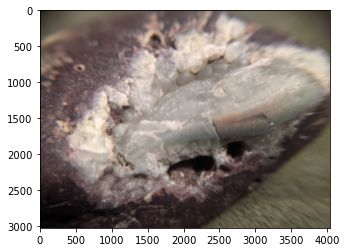

In [4]:
#load our shit
base_img=gaussian(plt.imread('rock3.jpg'),sigma=5,multichannel=True,preserve_range=False)
all_images=[]
for filename in glob.glob('*.jpg'):
    all_images.append(gaussian(plt.imread(filename),sigma=5,multichannel=True,preserve_range=False))
    
plt.imshow(base_img) #show an input image

In [5]:
#get shit lined up properly
registered_images=[]
for image in all_images:
    corrected_img=align_image(base_img,image)
    registered_images.append(corrected_img)


In [6]:
#replace base image with sharpest image, one nXn window at a time
window_size=100
stacked_img=base_img.copy()
img_width=base_img.shape[0]
img_length=base_img.shape[1]
for window_x in range(0,img_width,window_size):
    if window_x+window_size>img_width:
        break
    for window_y in range(0,img_length,window_size):
        if window_y+window_size>img_length:
            break
        my_sharpness=sharpness_score(base_img[window_x:window_x+window_size,window_y:window_y+window_size])
        for image in registered_images:
            new_sharpness=sharpness_score(image[window_x:window_x+window_size,window_y:window_y+window_size])
            if new_sharpness>=my_sharpness:
                stacked_img[window_x:window_x+window_size,window_y:window_y+window_size,:]=image[window_x:window_x+window_size,window_y:window_y+window_size,:]
                my_sharpness=new_sharpness
            else:
                stacked_img[window_x:window_x+window_size,window_y:window_y+window_size,:]=base_img[window_x:window_x+window_size,window_y:window_y+window_size,:]

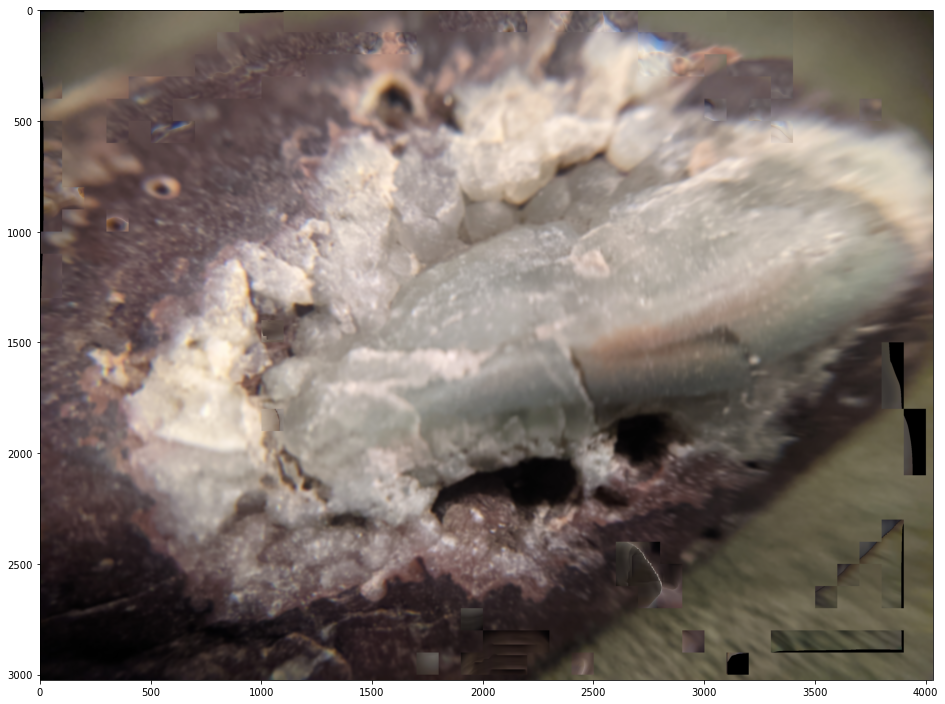

In [7]:
#show final stacked image
plt.figure(figsize=(16,24))
plt.imshow(stacked_img)

In [8]:
plt.imsave('out.jpg',stacked_img)